#Transfer Learning with TensorFlow Part 3: Scaling Up

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Fodd101

Our goal is to beat the original Food101 paper with 10% of training.

Our baseline to beat is 50.76% accuray across 101 classes.

##Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, lets download them

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-18 14:52:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-18 14:52:01 (76.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Import hepler function
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir,compare_historys

## 101 Food Classes:working with less daata

Our goal is to beat the original Food101 paper with 10% of training data, so let's download it

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

--2023-08-18 14:52:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 209.85.145.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   238MB/s    in 6.1s    

2023-08-18 14:52:12 (252 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
#How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/omelette'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/greek_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_

In [ ]:
#Setup data inputs
import tensorflow as tf
Img_size=(224,224)
train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=Img_size)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=Img_size,
                                                              shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Train a big dog model with transfer learning on 10% of the data

Here are the steps  we're going to take:
* Create a model checkpoint
* Create a data augmentation layer
* Build  a headless functional EfficientNetB0 backboned-model
* Compile our model
* Feature extraction for 5 epochs on train dataset and validate on 15% of test data

In [ ]:
#Create checkpoint callback
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor="val_accuracy",
                                                       save_best_only=True)

In [ ]:
#Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Setup data augmentation
data_augmentation=Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2)
],name="data_augmentation")

In [ ]:
#Setup the base model and freeze its layers
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Setup model architecture with trainable top layers
inputs=layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name="global_avergae_pool_layer")(x)
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax")(x)
model=tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
#Get a summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avergae_pool_layer (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
#Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
#Fit
history_1=model.fit(train_data_all_10_percent,
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=int(0.25*len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 123s 451ms/step - loss: 3.3955 - accuracy: 0.2661 - val_loss: 2.4781 - val_accuracy: 0.4369
Epoch 2/5
237/237 [==============================] - 89s 373ms/step - loss: 2.1986 - accuracy: 0.4962 - val_loss: 2.0263 - val_accuracy: 0.4987
Epoch 3/5
237/237 [==============================] - 80s 336ms/step - loss: 1.8216 - accuracy: 0.5683 - val_loss: 1.8488 - val_accuracy: 0.5303
Epoch 4/5
237/237 [==============================] - 72s 303ms/step - loss: 1.6088 - accuracy: 0.6117 - val_loss: 1.7837 - val_accuracy: 0.5311
Epoch 5/5
237/237 [==============================] - 60s 251ms/step - loss: 1.4567 - accuracy: 0.6426 - val_loss: 1.7156 - val_accuracy: 0.5466


In [ ]:
#Evaluate on whole test data
results_1=model.evaluate(test_data)

790/790 [==============================] - 58s 74ms/step - loss: 1.5882 - accuracy: 0.5792


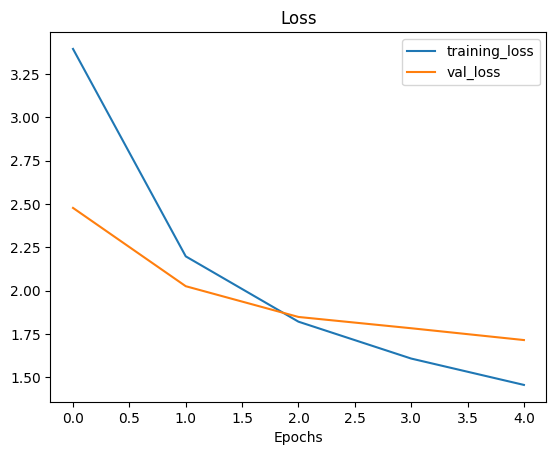

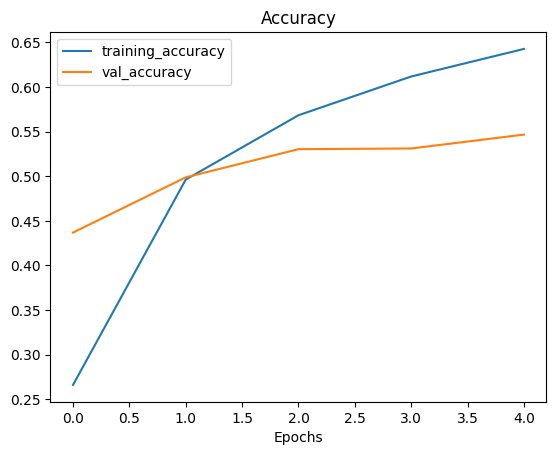

In [ ]:
plot_loss_curves(history_1)

#Fine-tuning

In [ ]:
#Unfreeze all of the layers of the base model
base_model.trainable=True

#Refreeze every layer except last five
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
#Recompile model with lower learning
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
#What layers in the model are trainable?
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avergae_pool_layer True
dense True


In [ ]:
#Check which layers are trainable in our base model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
#Fine-tuning for 5 more epochs
fine_tune_epochs=10

#Fine tune our model
history_2=model.fit(train_data_all_10_percent,
                    epochs=fine_tune_epochs,
                    validation_data=test_data,
                    validation_steps=int(0.25*len(test_data)),
                    initial_epoch=history_1.epoch[-1])

Epoch 5/10
237/237 [==============================] - 79s 290ms/step - loss: 1.2156 - accuracy: 0.6850 - val_loss: 1.6678 - val_accuracy: 0.5508
Epoch 6/10
237/237 [==============================] - 57s 239ms/step - loss: 1.1025 - accuracy: 0.7101 - val_loss: 1.6426 - val_accuracy: 0.5581
Epoch 7/10
237/237 [==============================] - 62s 260ms/step - loss: 1.0162 - accuracy: 0.7311 - val_loss: 1.6633 - val_accuracy: 0.5596
Epoch 8/10
237/237 [==============================] - 52s 219ms/step - loss: 0.9419 - accuracy: 0.7493 - val_loss: 1.6521 - val_accuracy: 0.5620
Epoch 9/10
237/237 [==============================] - 50s 211ms/step - loss: 0.8759 - accuracy: 0.7657 - val_loss: 1.6306 - val_accuracy: 0.5630
Epoch 10/10
237/237 [==============================] - 50s 207ms/step - loss: 0.8342 - accuracy: 0.7757 - val_loss: 1.6439 - val_accuracy: 0.5646


In [ ]:
#Evaluate on whole test data
results_2=model.evaluate(test_data)

790/790 [==============================] - 66s 83ms/step - loss: 1.5064 - accuracy: 0.6016


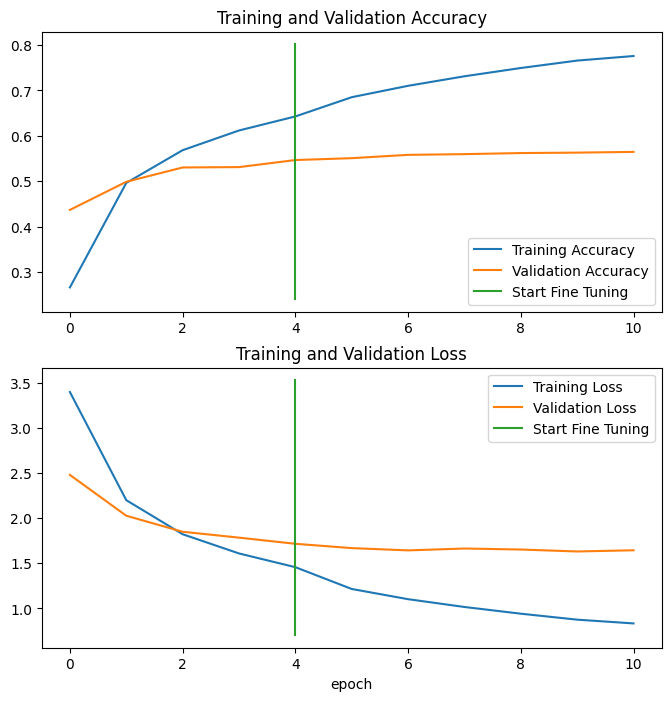

In [ ]:
#Compare the histories of feature extarction with fun tuning model
compare_historys(original_history=history_1,
                 new_history=history_2,
                 initial_epochs=5)

##Evaluating the performance of the big dog model across all  different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong

In [ ]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-08-18 15:08:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   162MB/s    in 0.3s    

2023-08-18 15:08:26 (162 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
#Load in saved model
loaded_model=tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
#Evaluate loaded model
results_3=loaded_model.evaluate(test_data)

790/790 [==============================] - 65s 80ms/step - loss: 1.8027 - accuracy: 0.6078


##Making predictions with our trainned model

In [ ]:
#Make predictions with model
preds_probs=model.predict(test_data,verbose=1)

790/790 [==============================] - 65s 81ms/step


In [ ]:
len(test_data)

790

In [ ]:
#How many predictions are there?
len(preds_probs)

25250

In [ ]:
#Whats the shape of our prediction?
preds_probs.shape

(25250, 101)

In [ ]:
#Lets see what the first 10 predicitions look like
preds_probs[:10]

array([[1.3249482e-01, 9.0894151e-05, 1.9545570e-01, ..., 3.1456548e-05,
        1.6636587e-03, 3.9778762e-02],
       [9.0547645e-01, 4.3842650e-08, 7.5448345e-04, ..., 6.6912663e-03,
        2.8246981e-07, 1.2782049e-05],
       [5.9964019e-01, 7.1872910e-03, 2.2343583e-02, ..., 4.1279872e-04,
        2.9316061e-04, 2.1650486e-03],
       ...,
       [2.8548050e-01, 1.4570662e-06, 5.9364003e-04, ..., 4.7781795e-02,
        3.4467981e-04, 2.9423757e-04],
       [1.4330167e-01, 5.3668482e-04, 1.4723723e-01, ..., 2.6461860e-04,
        1.6230214e-04, 1.6934679e-04],
       [7.3067868e-01, 3.6116813e-07, 5.2023382e-04, ..., 5.5796015e-03,
        5.7272803e-07, 6.6953554e-04]], dtype=float32)

Our model outputs a prediction probability array (with n number of variables where n is number of classes) for each sample passed to the  predict method.

In [ ]:
#We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0:{len(preds_probs[0])}")
print(f"What pred prob 0 looks like: {preds_probs[0]}")
print(f"The class with highest predicted probability by thee model for samole 0:{preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0:101
What pred prob 0 looks like: [1.32494822e-01 9.08941511e-05 1.95455700e-01 5.74661271e-07
 5.52151505e-06 3.57036765e-06 1.16814859e-04 6.92421008e-06
 2.65275612e-02 4.02969919e-04 1.23889254e-06 5.14420299e-06
 3.78104975e-04 4.35715805e-07 9.99491662e-03 3.19851190e-03
 1.80126954e-05 6.07407186e-04 1.19202575e-02 4.81257121e-06
 6.98982098e-04 9.99960139e-06 2.95382255e-04 7.57797316e-05
 1.71839655e-03 5.41133573e-03 8.10109894e-04 1.57101036e-04
 2.62623608e-01 1.82532531e-03 3.15393459e-06 8.56471946e-04
 3.53369163e-04 3.21402325e-07 7.71959918e-03 6.81400024e-06
 3.07576032e-04 1.80102896e-03 3.67535353e-02 1.03109887e-04
 3.48851841e-04 3.52463662e-03 1.64523066e-04 9.66586049e-06
 6.40810322e-05 2.70431447e-05 8.15081177e-04 7.05263810e-05
 8.99514475e-07 3.86758745e-02 2.78329273e-04 3.50715018e-05
 5.75527959e-02 2.46495325e-02 3.31250449e-05 1.41783003e-02
 3.05325240e-02 1.23884005e-03 2.92948214e-03 3.86152788e-05
 6.2

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
 #Get the pred classe of each label
 pred_classes=preds_probs.argmax(axis=1)

 #How do they look
 pred_classes[:10]

array([28,  0,  0, 38,  8, 78, 29,  0,  9,  0])

Now we've got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the original test dataset labels

In [ ]:
#To get our test labels we need to unravel our test_data BatchDataset
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
#How many y_labels are there?
len(y_labels)

25250

##Evaluating our model's predictions

One way to check our model's predictions array is in the same order as our test labels array is to find accuracy score

In [ ]:
#Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy=accuracy_score(y_true=y_labels,
                                y_pred=pred_classes)
sklearn_accuracy

0.6015841584158416

##Let's get visual:making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
#Get a list of class names
class_names=test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#We need to make some changes to our make_confusion_matrix function to ensure x labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  #Changed (plot x-labels vertically)
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

##Let's keep the evaluation train going time for a classification report

Scikit-learn has a helpfulfunction for acquiring  many different classification metrics per class called classification_report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.30      0.19      0.23       250
           1       0.49      0.75      0.60       250
           2       0.70      0.59      0.64       250
           3       0.84      0.52      0.64       250
           4       0.65      0.40      0.50       250
           5       0.48      0.44      0.46       250
           6       0.76      0.78      0.77       250
           7       0.80      0.75      0.77       250
           8       0.27      0.50      0.35       250
           9       0.33      0.72      0.46       250
          10       0.51      0.44      0.47       250
          11       0.85      0.47      0.61       250
          12       0.67      0.63      0.65       250
          13       0.54      0.57      0.56       250
          14       0.54      0.60      0.57       250
          15       0.36      0.43      0.39       250
          16       0.69      0.56      0.62       250
          17       0.33    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How abour we create a visualization to get a better understanding

In [ ]:
#Get a dictionar of the classification report
classification_report_dict=classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'precision': 0.2981366459627329,
  'recall': 0.192,
  'f1-score': 0.23357664233576644,
  'support': 250},
 '1': {'precision': 0.49473684210526314,
  'recall': 0.752,
  'f1-score': 0.5968253968253968,
  'support': 250},
 '2': {'precision': 0.7014218009478673,
  'recall': 0.592,
  'f1-score': 0.6420824295010846,
  'support': 250},
 '3': {'precision': 0.8376623376623377,
  'recall': 0.516,
  'f1-score': 0.6386138613861386,
  'support': 250},
 '4': {'precision': 0.6516129032258065,
  'recall': 0.404,
  'f1-score': 0.49876543209876534,
  'support': 250},
 '5': {'precision': 0.4823008849557522,
  'recall': 0.436,
  'f1-score': 0.45798319327731096,
  'support': 250},
 '6': {'precision': 0.7587548638132295,
  'recall': 0.78,
  'f1-score': 0.7692307692307693,
  'support': 250},
 '7': {'precision': 0.7957446808510639,
  'recall': 0.748,
  'f1-score': 0.7711340206185568,
  'support': 250},
 '8': {'precision': 0.2727272727272727,
  'recall': 0.504,
  'f1-score': 0.3539325842696629,
  'suppo

#Let's plot all of our classes F1-scores


In [ ]:
#Create empty dictionay
class_f1_scores={}
#Loop through classification dictonary items
for k,v in classification_report_dict.items():
  if k=="accuracy":#stop once we get to accuravy key
    break
  else:
    #Add class names  and f1=scores
    class_f1_scores[class_names[int(k)]]=v["f1-score"]
class_f1_scores

{'apple_pie': 0.23357664233576644,
 'baby_back_ribs': 0.5968253968253968,
 'baklava': 0.6420824295010846,
 'beef_carpaccio': 0.6386138613861386,
 'beef_tartare': 0.49876543209876534,
 'beet_salad': 0.45798319327731096,
 'beignets': 0.7692307692307693,
 'bibimbap': 0.7711340206185568,
 'bread_pudding': 0.3539325842696629,
 'breakfast_burrito': 0.4559193954659949,
 'bruschetta': 0.47334754797441364,
 'caesar_salad': 0.6066838046272494,
 'cannoli': 0.6515463917525773,
 'caprese_salad': 0.556420233463035,
 'carrot_cake': 0.568738229755179,
 'ceviche': 0.3933823529411765,
 'cheese_plate': 0.6150442477876107,
 'cheesecake': 0.3993558776167472,
 'chicken_curry': 0.4636363636363636,
 'chicken_quesadilla': 0.6558139534883721,
 'chicken_wings': 0.7329192546583851,
 'chocolate_cake': 0.5487804878048781,
 'chocolate_mousse': 0.3602058319039451,
 'churros': 0.7444933920704846,
 'clam_chowder': 0.7257731958762885,
 'club_sandwich': 0.6885880077369438,
 'crab_cakes': 0.4013050570962479,
 'creme_brule

In [ ]:
#Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores=pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)


In [ ]:
f1_scores

class_name  f1-score
33              edamame  0.970530
69              oysters  0.853755
63             macarons  0.846847
91  spaghetti_carbonara  0.837037
51            guacamole  0.835249
..                  ...       ...
82              ravioli  0.327559
39            foie_gras  0.309783
93                steak  0.304251
77            pork_chop  0.289417
0             apple_pie  0.233577

[101 rows x 2 columns]

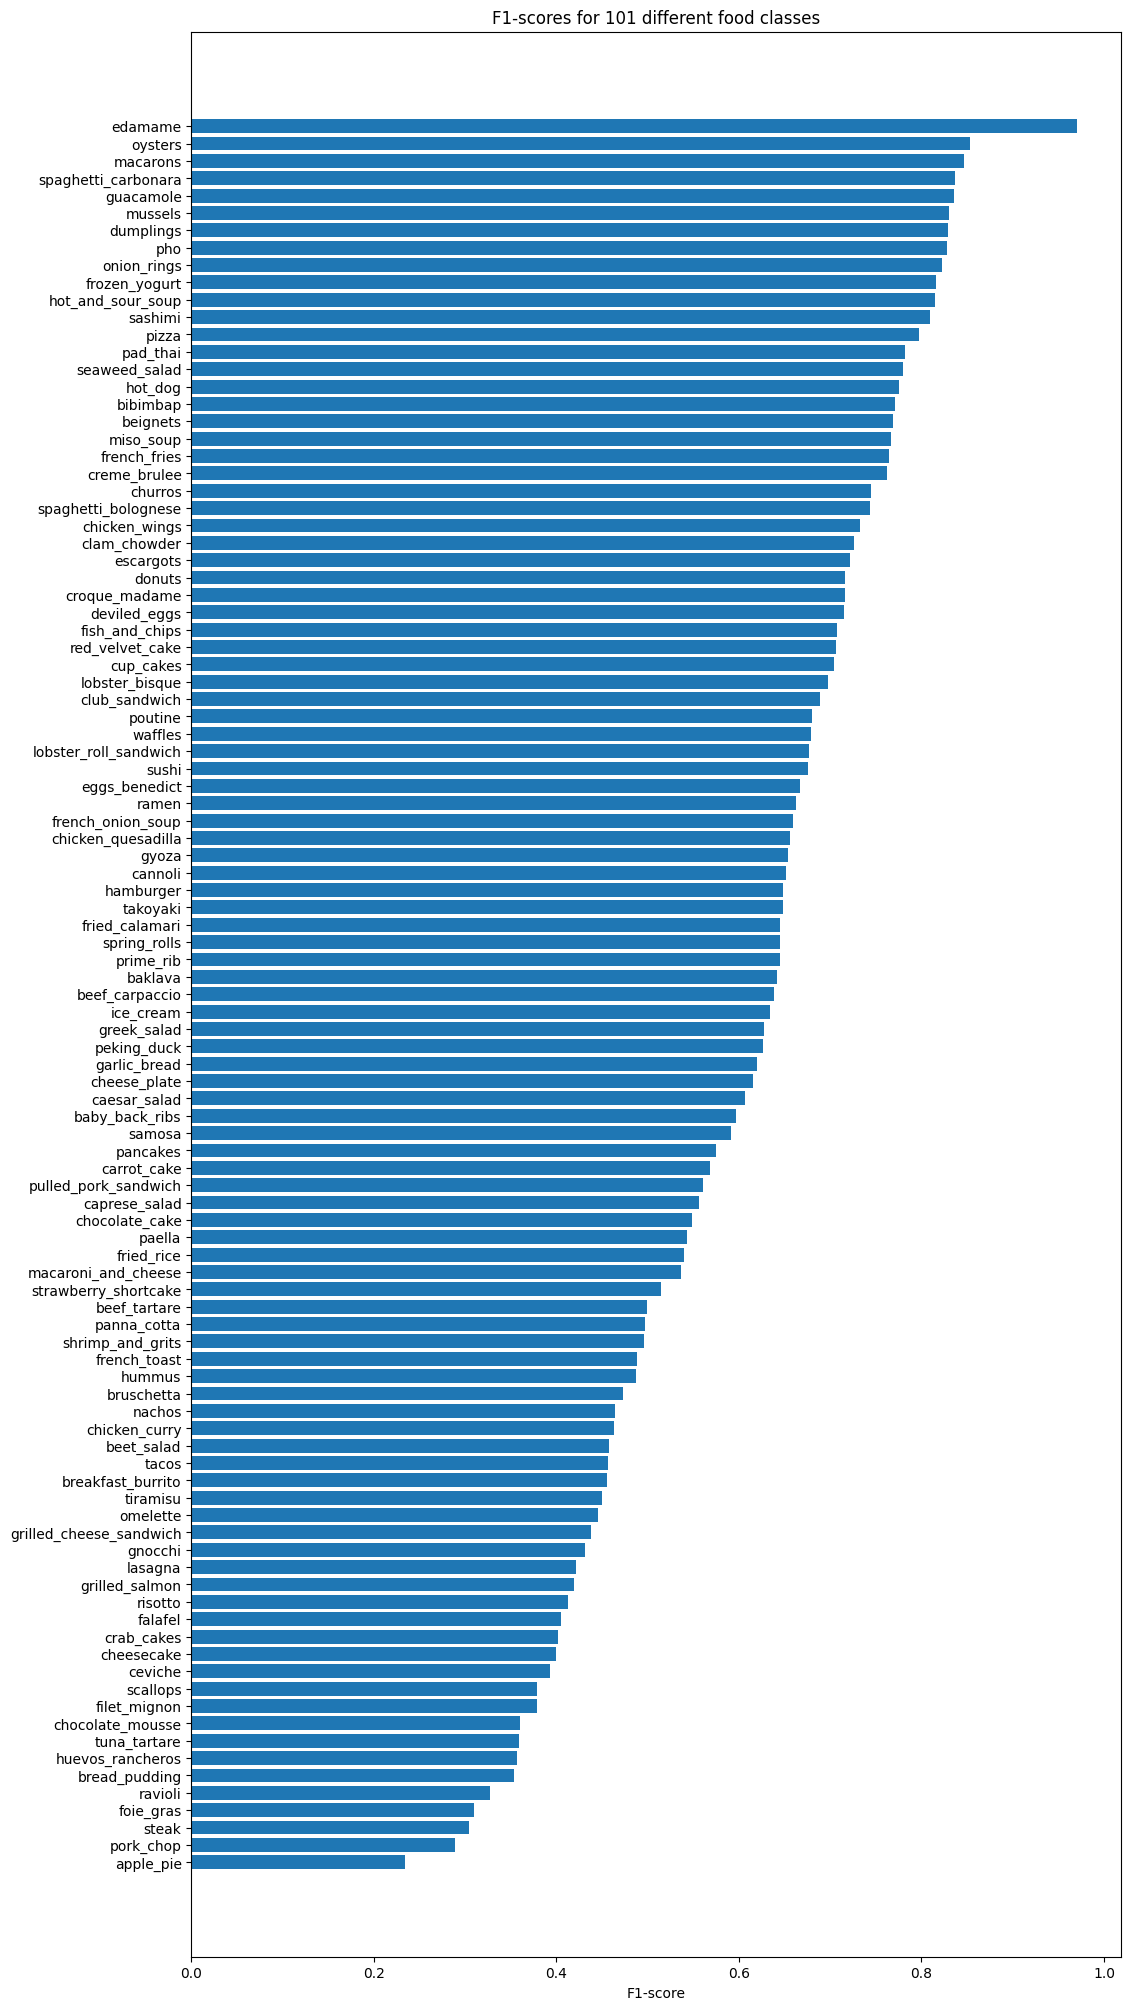

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(12,25))
scores=ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_name"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different food classes")
ax.invert_yaxis();

##Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset

To visualize our model's prediction on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read.file()
* Turn the image into a Tensor using tf.io.decode.image()
* Resize the image tensor to be the same size as the images in our model has trainned on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 and 1 if necessary


In [ ]:
#Create a function to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image from filenmae, turns it into a tensor and reshapes into specified shape(img_shape,img_shape,colo_channels=3)

  Args:
    filename(str):path to target image
    image_shape(int):height/width dimension of the target image size
    scale(bool):scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape(img_shape,imag_sape,3)
  """
  #Read int the image
  img=tf.io.read_file(filename)

  #Decode image into tensor
  img=tf.io.decode_image(img,channels=3)

  #Resize the image
  img=tf.image.resize(img,[img_shape,img_shape])

  #Scale? Yes/no
  if scale:
    #rescale the image
    return img/255.
  else:
    return img

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image along with the model's predictions, prediction probability and truth label

1/1 [==============================] - 0s 25ms/step


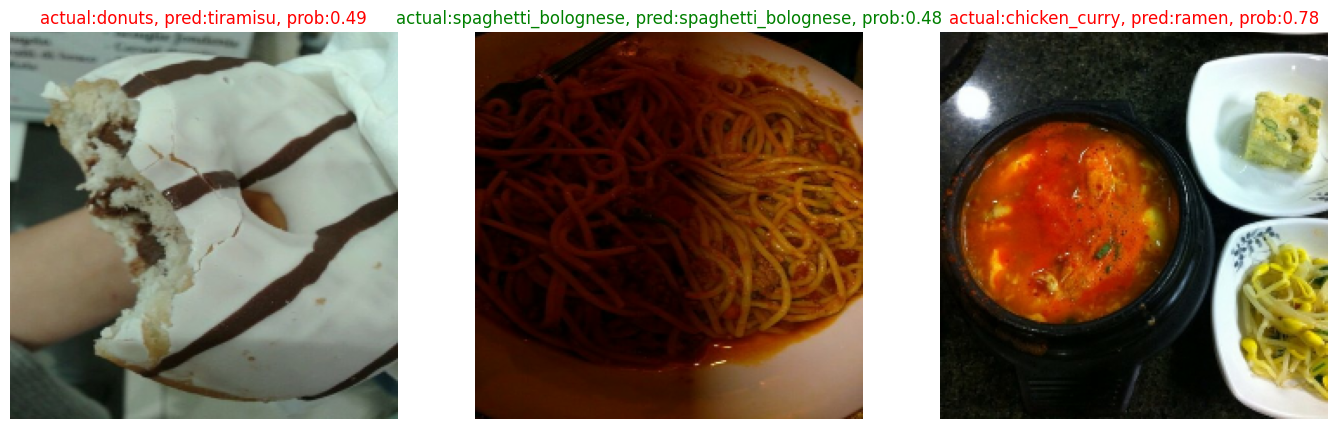

In [ ]:
#Make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  #Choose a random iamge from a random class
  class_name=random.choice(class_names)
  filename=random.choice(os.listdir(test_dir+"/"+class_name))
  filepath=test_dir+class_name+"/"+filename

  #Load the image and make prediction
  img=load_and_prep_image(filepath,scale=False)
  img_expanded=tf.expand_dims(img,axis=0)
  pred_prob=model.predict(img_expanded)
  pred_class=class_names[pred_prob.argmax()]
  #print(pred_prob)
  #print(pred_class)

  #Plot the image
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:#if predicted class matches truth class, make text green
    title_color="g"
  else:
    title_color="r"
  plt.title(f"actual:{class_name}, pred:{pred_class}, prob:{pred_prob.max():.2f}",color=title_color)
  plt.axis(False);

##Finding the most wrong predictions

To find out where our model is most wrong ,let's write some code to find out the following:
1. Get all of the image file paths in test dataset using list_files() method.
2. Create apandas DataFrame of the image filepaths, ground truth labels, predicted classes(from our models),
max prediction probabilities
3. Use our DataFrame  to find all the wrong predictions
4. Sort the DataFrame based on wrong predictions
5. Visualize the images with highest prediction probabilities but have the wrong prediction.

In [ ]:
#Get all of thr image file paths in thr dataset
filepaths=[]
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
#2. Create a DtaFrame of different parameters for each of out test images
import pandas as pd
pred_pd=pd.DataFrame({"img_path":filepaths,
                      "y_true":y_labels,
                      "y_pred":pred_classes,
                      "pred_conf":preds_probs.max(axis=1),
                      "y_true_classname":[class_names[i] for i in y_labels],
                      "y_pred_classname":[class_names[i] for i in pred_classes]})
pred_pd

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      28   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      38   
4      b'/content/101_food_classes_10_percent/test/ap...       0       8   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.262624        apple_pie         croque_madame  
1       0.905476        apple_pie             apple_pie  
2       0.599640        apple_pie             apple_pie  
3       0.151818        apple_pie        fish_and_chips  
4       0.434382        apple_pie         bread_pudding  
...          ...              ...                   ...  
25245   0.966344          waffles               waffles  
25246   0.837449          waffles          cheese_plate  
25247   0.425928          waffles               waffles  
25248   0.247505          waffles  strawberry_shortcake  
25249   0.330806          waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
#3. Find out in our DataFrame which predictions are wrong
pred_pd["pred_correct"]=pred_pd["y_true"]==pred_pd["y_pred"]
pred_pd.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      28   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      38   
4  b'/content/101_food_classes_10_percent/test/ap...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.262624        apple_pie    croque_madame         False  
1   0.905476        apple_pie        apple_pie          True  
2   0.599640        apple_pie        apple_pie          True  
3   0.151818        apple_pie   fish_and_chips         False  
4   0.434382        apple_pie    bread_pudding         False

In [ ]:
#4. Sort our DataFrame to have more wrong predictions at the top
top_100_wrong=pred_pd[pred_pd["pred_correct"]==False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
191    b'/content/101_food_classes_10_percent/test/ap...       0      31   
10741  b'/content/101_food_classes_10_percent/test/fr...      42       1   
23300  b'/content/101_food_classes_10_percent/test/st...      93       1   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
19430  b'/content/101_food_classes_10_percent/test/po...      77       1   
8794   b'/content/101_food_classes_10_percent/test/es...      35      41   
15142  b'/content/101_food_classes_10_percent/test/lo...      60      64   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
10013  b'/content/101_food_classes_10_percent/test/fr...      40      43   
16271  b'/content/101_food_classes_10_percent/test/mu...      65      69   
23935  b'/content/101_food_classes_10_percent/test/su...      95      86   
9326   b'/content/101_food_classes_10_percent/test/fi...      37      79   
7194   b'/content/101_food_classes_10_percent/test/cr...      28       7   
15826  b'/content/101_food_classes_10_percent/test/ma...      63      29   
22606  b'/content/101_food_classes_10_percent/test/sp...      90       1   
7295   b'/content/101_food_classes_10_percent/test/cu...      29      31   
5114   b'/content/101_food_classes_10_percent/test/ch...      20      38   

       pred_conf     y_true_classname   y_pred_classname  pred_correct  
23797   0.999740                sushi            sashimi         False  
21810   0.999020             scallops          cup_cakes         False  
191     0.998751            apple_pie             donuts         False  
10741   0.996725         french_toast     baby_back_ribs         False  
23300   0.996436                steak     baby_back_ribs         False  
18001   0.996192             pancakes           omelette         False  
11642   0.995159         garlic_bread         bruschetta         False  
19430   0.994803            pork_chop     baby_back_ribs         False  
8794    0.994756            escargots  french_onion_soup         False  
15142   0.994701       lobster_bisque          miso_soup         False  
17855   0.994334               paella            mussels         False  
10013   0.993918         french_fries     fried_calamari         False  
16271   0.993705              mussels            oysters         False  
23935   0.993389                sushi            sashimi         False  
9326    0.992454         filet_mignon          prime_rib         False  
7194    0.992451        croque_madame           bibimbap         False  
15826   0.992448             macarons          cup_cakes         False  
22606   0.991409  spaghetti_bolognese     baby_back_ribs         False  
7295    0.991359            cup_cakes             donuts         False  
5114    0.990978        chicken_wings     fish_and_chips         False

In [ ]:
#5. Visualize the test data sample which have the wrong prediction but highest pred probabilities
images_to_view=9
start_index=0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img=load_and_prep_image(row[1],scale=False)
  _,_,_,_,pred_prob,y_true_classname,y_pred_classname,_=row
  plt.imshow(img/255.)
  plt.title(f"actual:{y_true_classname},pred:{y_pred_classname}\nprob:{pred_prob}")
  plt.axis(False)

##Testout the big model on our owm custom images

In [ ]:
#Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2023-08-18 16:26:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 142.251.171.128, 74.125.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  58.7MB/s    in 0.2s    

2023-08-18 16:26:02 (58.7 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
#Get the custom food images filepaths
custom_food_images=["custom_food_images/"+img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 [==============================] - 0s 51ms/step


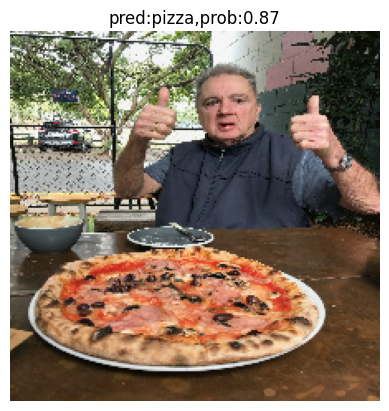

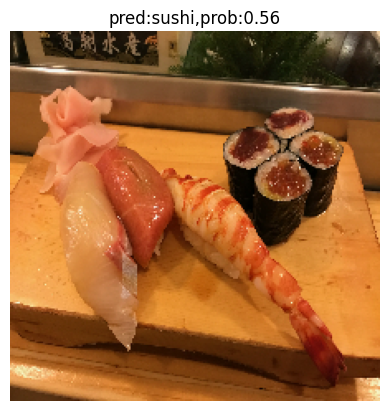

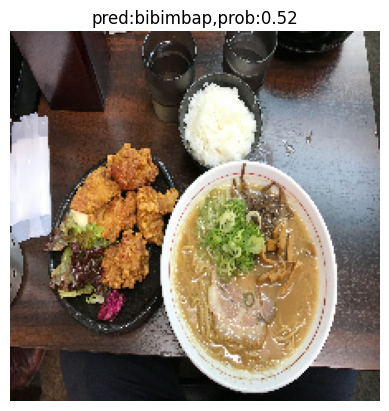

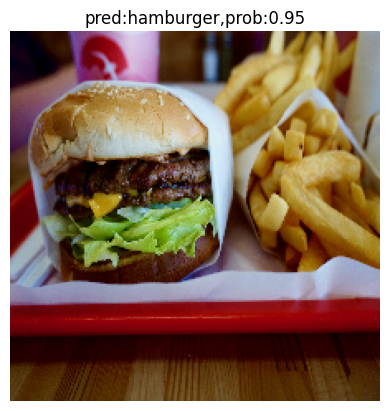

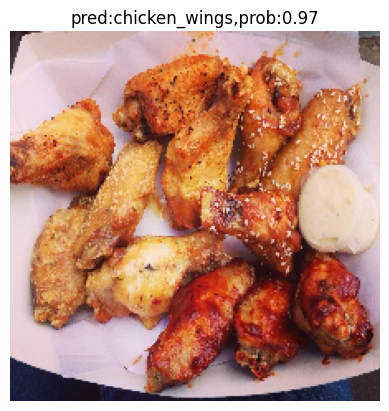

In [ ]:
#Make predictions on and plot custom food images
for img in custom_food_images:
  img=load_and_prep_image(img,scale=False)
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[pred_prob.argmax()]
  #Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred:{pred_class},prob:{pred_prob.max():.2f}")
  plt.axis(False)